# Basic Losses

This notebook demonstrates how the loss functions in `captum.optim.loss` can be modified or combined to create interesting results.

We will first cover "negative" visualizations where we negate the loss functions and show how these visualizations are semantically "opposite" to the original visualizations. We then cover basic interpolation between features by adding two loss functions together. Along the way, we also show how to visualize a *batch* of images where each image in the batch is optimized with a different loss function.

Examples shown here cover both `alexnet` and `googlenet` models from `torchvision` and `optim.captum` respectively. Feel free to try these out with other models!

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision
from torchvision.models import alexnet

import captum.optim as opt
from captum.optim.models import googlenet, InceptionV1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

alexnet_model = alexnet(pretrained=True).to(device)
googlenet_model = googlenet(pretrained=True).to(device)

In [2]:
# Helper function for visualizations
def visualize(model: torch.nn.Module, image: opt.images.ImageParameterization, loss_fn: opt.loss.Loss) -> None:
    obj = opt.InputOptimization(model, loss_fn, image)
    history = obj.optimize()
    image().show()

## Negative Channel Visualizations

With interpretability via optimization, we can visualize "extremely positive examples" that maximize activations in the positive direction.

Equally informative are "extremely negative examples" that we can visualize by simply negating the loss function. These examples maximize the activations in the opposite direction and as we will see, the visualizations are often semantically opposite as well.

We do this by initializing an image of batch 2 and then indicating the appropriate `batch_index` when initializing the loss functions. To combine the loss functions, we can simply sum up the losses.

In this example, we see that the original loss function (left) gives us a black and white image with vertical-ish patterns. With the negated loss function (right), we get a colored image that has subtle horizontal patterns. 

  0%|          | 0/512 [00:00<?, ? step/s]

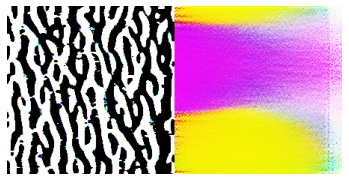

In [3]:
# Generate a visualization where the left and right images
# optimize losses in opposite directions.
image = opt.images.NaturalImage((224, 224), batch=2).to(device)
loss_fn = sum([
    opt.loss.ChannelActivation(alexnet_model.features[1], 5, batch_index=0),
    -opt.loss.ChannelActivation(alexnet_model.features[1], 5, batch_index=1),
])
visualize(alexnet_model, image, loss_fn)

As we go deeper, the negated loss functions may be less semantically meaningful, although we may still see contrasting features such as rigid angles (left) versus flowing curves (right).

  0%|          | 0/512 [00:00<?, ? step/s]

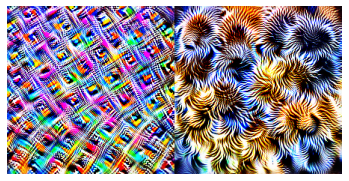

In [4]:
image = opt.images.NaturalImage((224, 224), batch=2).to(device)
loss_fn = sum([
    opt.loss.ChannelActivation(alexnet_model.features[10], 1, batch_index=0),
    -opt.loss.ChannelActivation(alexnet_model.features[10], 1, batch_index=1),
])
visualize(alexnet_model, image, loss_fn)

We can also reproduce the results from the original negative neurons [Lucid notebook](https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/feature-visualization/negative_neurons.ipynb) with the `googlenet` model.

  0%|          | 0/512 [00:00<?, ? step/s]

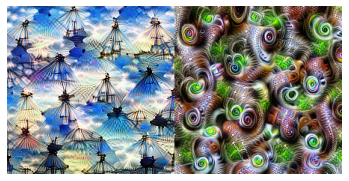

In [5]:
image = opt.images.NaturalImage((224, 224), batch=2).to(device)
loss_fn = sum([
    opt.loss.ChannelActivation(googlenet_model.mixed4a, 492, batch_index=0),
    -opt.loss.ChannelActivation(googlenet_model.mixed4a, 492, batch_index=1),
])
visualize(googlenet_model, image, loss_fn)

  0%|          | 0/512 [00:00<?, ? step/s]

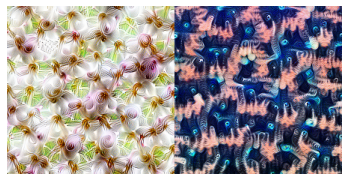

In [6]:
image = opt.images.NaturalImage((224, 224), batch=2).to(device)
loss_fn = sum([
    opt.loss.ChannelActivation(googlenet_model.mixed4a, 104, batch_index=0),
    -opt.loss.ChannelActivation(googlenet_model.mixed4a, 104, batch_index=1),
])
visualize(googlenet_model, image, loss_fn)

  0%|          | 0/512 [00:00<?, ? step/s]

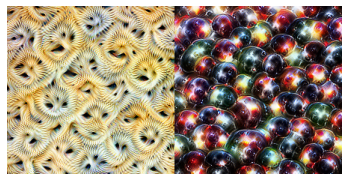

In [7]:
image = opt.images.NaturalImage((224, 224), batch=2).to(device)
loss_fn = sum([
    opt.loss.ChannelActivation(googlenet_model.mixed4b, 154, batch_index=0),
    -opt.loss.ChannelActivation(googlenet_model.mixed4b, 154, batch_index=1),
])
visualize(googlenet_model, image, loss_fn)

## Combining Losses

We can also combine losses which will intuitively result in combinations of visualizations.

For example, we can combine a channel that activates on black and white stripes with a channel that activates on a furry texture, to create a visualization that mixes the two.

Similar to the previous section, we do this by first initializing an image of batch 3 and specify the appropriate `batch_index` when declaring the losses. Finally, sum up all of the losses.

  0%|          | 0/512 [00:00<?, ? step/s]

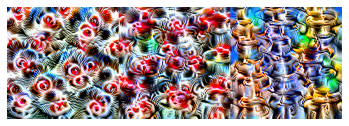

In [8]:
# Generate a visualization where the middle image is a combination
# of the left and right.
image = opt.images.NaturalImage((224, 224), batch=3).to(device)
loss_fn = sum([
    opt.loss.ChannelActivation(alexnet_model.features[10], 0, batch_index=0),
    opt.loss.ChannelActivation(alexnet_model.features[10], 0, batch_index=1),
    opt.loss.ChannelActivation(alexnet_model.features[10], 2, batch_index=1),
    opt.loss.ChannelActivation(alexnet_model.features[10], 2, batch_index=2),
])
visualize(alexnet_model, image, loss_fn)

We can also combine losses from different layers. However, note that when mixing activations from different layers, we sometimes have to scale the loss functions appropriately. Specifically, we may need to scale up the earlier layers, since the magnitude of the loss may be smaller.

  0%|          | 0/512 [00:00<?, ? step/s]

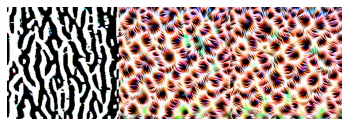

In [9]:
# Without scaling, the output is overwhelmed by the later layer
image = opt.images.NaturalImage((224, 224), batch=3).to(device)
loss_fn = sum([
    opt.loss.ChannelActivation(alexnet_model.features[1], 5, 0),
    opt.loss.ChannelActivation(alexnet_model.features[1], 5, 1), 
    opt.loss.ChannelActivation(alexnet_model.features[9], 8, 1),
    opt.loss.ChannelActivation(alexnet_model.features[9], 8, 2),
])
visualize(alexnet_model, image, loss_fn)

  0%|          | 0/512 [00:00<?, ? step/s]

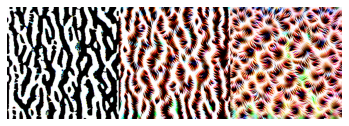

In [10]:
# With appropriate scaling, we get a balanced mix.
image = opt.images.NaturalImage((224, 224), batch=3).to(device)
loss_fn = sum([
    opt.loss.ChannelActivation(alexnet_model.features[1], 5, 0),
    # Scale up loss of earlier layer
    25*opt.loss.ChannelActivation(alexnet_model.features[1], 5, 1), 
    opt.loss.ChannelActivation(alexnet_model.features[9], 8, 1),
    opt.loss.ChannelActivation(alexnet_model.features[9], 8, 2),
])
visualize(alexnet_model, image, loss_fn)

Again we can reproduce the results from the original Neuron Interaction [Lucid notebook](https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/feature-visualization/neuron_interaction.ipynb) with the `googlenet` model.

In [11]:
# From the original Neural Interaction Lucid notebook
# Comment out the different neurons and run the next cell!

neuron1 = (googlenet_model.mixed4b, 111)     # large fluffy
# neuron1 = (googlenet_model.mixed3a, 139)   # pointilist
# neuron1 = (googlenet_model.mixed3b,  81)   # brush trokes
# neuron1 = (googlenet_model.mixed4a,  97)   # wavy
# neuron1 = (googlenet_model.mixed4a,  41)   # frames
# neuron1 = (googlenet_model.mixed4a, 479)   # B/W

neuron2 = (googlenet_model.mixed4a, 476)     # art
# neuron2 = (googlenet_model.mixed4b, 360)   # lattices
# neuron2 = (googlenet_model.mixed4b, 482)   # arcs
# neuron2 = (googlenet_model.mixed4c, 440)   # small fluffy
# neuron2 = (googlenet_model.mixed4d, 479)   # bird beaks
# neuron2 = (googlenet_model.mixed4e, 718)   # shoulders

  0%|          | 0/512 [00:00<?, ? step/s]

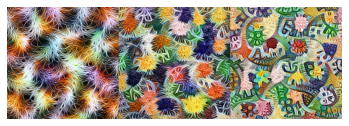

In [12]:
image = opt.images.NaturalImage((224, 224), batch=3).to(device)
loss_fn = sum([
    opt.loss.ChannelActivation(neuron1[0], neuron1[1], 0),
    opt.loss.ChannelActivation(neuron1[0], neuron1[1], 1), 
    opt.loss.ChannelActivation(neuron2[0], neuron2[1], 1),
    opt.loss.ChannelActivation(neuron2[0], neuron2[1], 2),
])
visualize(googlenet_model, image, loss_fn)